## Optimizing rotation during training

We want a model that will only learn a subset of the input distibution, but can also generalize to all affine transforms of this, creating a model that is small but also generalizes well. We want a model that can do this on general datasets, not just ones already at a fixed orientation like MNIST.

* Goal is to make a network that will represent all images at some cannonical orientation while being trained on variable orientation images.
* This should result in an overall more simple model able to do the same work.
* Switch between optimizing the model parameters, and optimizing the network.
* Could also do it on one batch at a fixed orientation first, but this is much less cool so we won't

For each batch:
1. Optimize the rotation parameters (randomly), pick the best, couple SGD steps.
2. Do the backward pass to update the weights.

## Limitations:
This is implemented naively, with no attempt to be efficient. A much better approach would be to combine an STN in the optimization process, as although this is not always correct, it could be much faster than simple random search. Process of use STN, eval, use STN again, ..., but mixed in with randomness and SGD. This way you get the benefit of explicitly optimizing the objective, with faster speed than the random way.

In [1]:
import os
import sys
import json
import math
import random
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import display

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn.functional as F
from torchvision import transforms
import torchvision.transforms.functional as TF
from PIL import Image, ImageOps

sys.path.append(str(Path.cwd().parent))
from utils.display import read_img_to_np, torch_to_np
from utils.norms import MNIST_norm
import model.model as module_arch
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
from model.model import AffineVAE
from data_loader.data_loaders import make_generators_MNIST, make_generators_MNIST_CTRNFS

device = torch.device("cuda:0")

In [2]:
def get_model_loaders_config(PATH, device):#old_gpu='cuda:0', new_gpu='cuda:1'):
    """PATH: path to dir where training results of a run are saved"""
    PATH = Path(PATH)
    config_loc = PATH / 'config.json'
    weight_path = PATH / 'model_best.pth'
    config = json.load(open(config_loc))
    
    
    def get_instance(module, name, config, *args):
        return getattr(module, config[name]['type'])(*args, **config[name]['args'])

    data_loader = get_instance(module_data, 'data_loader', config)['train']
    valid_data_loader = get_instance(module_data, 'data_loader', config)['val']
    model = get_instance(module_arch, 'arch', config)
#     model = model.to(torch.device(new_gpu))
#     checkpoint = torch.load(weight_path, map_location={'cuda:0': 'cuda:1'})
    model = model.to(device)
    checkpoint = torch.load(weight_path)
    state_dict = checkpoint['state_dict']
    
    if config['n_gpu'] > 1:
        model = torch.nn.DataParallel(model)

    model.load_state_dict(state_dict)
    model = model.to(device).eval()
    
    loss_fn = get_instance(module_loss, 'loss', config)
    metric_fns = [getattr(module_metric, met) for met in config['metrics']]
    
    return model, data_loader, valid_data_loader, loss_fn, metric_fns, config

In [3]:
def pad_to_size(img, new_size):
    delta_width = new_size - img.size()[1]
    delta_height = new_size - img.size()[2]
    pad_width = delta_width //2
    pad_height = delta_height //2
    img = F.pad(img, (pad_height, pad_height, pad_width, pad_width), 'constant', 0)
    return img

def rotate_mnist_batch(x, return_size=40, fixed_rotation=None):
    """Rotate batch without squishing the img. Pad all imgs to same size"""
    batch_size = x.shape[0]
    rot_x = torch.zeros((batch_size, 1, return_size, return_size))
    for i in range(batch_size):
        img = TF.to_pil_image(x[i, :, :])
        if fixed_rotation:
            img = TF.rotate(img, fixed_rotation)

        img = transforms.ToTensor()(img)
        if return_size:
            img = pad_to_size(img, return_size)
        # MNIST norm, wrong because imgs are padded
        img = transforms.Normalize((0.1307,), (0.3081,))(img)
        rot_x[i, :, :, :] = img
    return rot_x

def AFFINE_MNIST_rot_perf(affine_model, data_loader, loss_fn, device, fixed_rotation, 
                          optimize=False, iterations=0, num_rand_restarts=200, num_imgs=1000):
    """Evaluate performance on MNIST Dataset using a given rotation
    Dataloader should be MNISTCustomTRNFS with size=28x28, unnormalized, not rotated"""

    with torch.cuda.device(device.index):
        affine_model = affine_model.to(device)
        affine_model.eval()
        total_loss = 0.0

        with torch.no_grad():
            for i, (data, target) in enumerate(data_loader):
                batch_size = data.shape[0]
                rot_x = rotate_mnist_batch(data, return_size=40, fixed_rotation=fixed_rotation)
                rot_x, target = rot_x.to(device), target.to(device)
                if optimize:
                    best_affine, loss = affine_model.optimize_rotation(rot_x, num_times=num_rand_restarts, 
                                                                       iterations=iterations)
                else:
                    output = affine_model(rot_x, deterministic=True, theta=0.0)
                    loss = loss_fn(output, rot_x).item()

                total_loss += loss * batch_size
                if i>num_imgs:
                    break

        n_samples = len(data_loader.sampler)
        return total_loss / num_imgs

# Performance of Batch-Optimized VAE
* Comparing the rotation optimized VAE to the one on random rotations to the one trained at a single orientation

In [ ]:
files_dict_loc = '/media/rene/data/MNIST/files_dict.pkl'
data_loaders = make_generators_MNIST_CTRNFS(files_dict_loc, batch_size=1, num_workers=4, 
                                            return_size=28, rotation_range=None, normalize=False)
                                            
config_loc = '/media/rene/data/equivariance/mnist/vae_mnist_L8/0129_171505'
VAE, data_loader, valid_data_loader, loss_fn, metric_fns, config = get_model_loaders_config(config_loc, device=device)#old_gpu='cuda:1', new_gpu='cuda:0')
VAE = VAE.to(device)
AffineVAE = getattr(module_arch, 'AffineVAE')
affine_model_single_rot = AffineVAE(pre_trained_VAE=VAE, img_size=28, input_dim=1, output_dim=1, latent_size=8, use_STN=False)
affine_model_single_rot = affine_model_single_rot.to(device)
                                                            
config_loc= '/media/rene/data/equivariance/mnist/vae_mnist_L8_rotate/0204_191133'
VAE, data_loader, valid_data_loader, loss_fn, metric_fns, config = get_model_loaders_config(config_loc, device=device)#old_gpu='cuda:1', new_gpu='cuda:0')
VAE = VAE.to(device)
AffineVAE = getattr(module_arch, 'AffineVAE')
affine_model_rand_rot = AffineVAE(pre_trained_VAE=VAE, img_size=28, input_dim=1, output_dim=1, latent_size=8, use_STN=False)
affine_model_rand_rot = affine_model_rand_rot.to(device)
                                            
config_loc = '/media/rene/data/equivariance/mnist/batch_avae_mnist_L8/0404_145427'
affine_model_opt_rot, data_loader, valid_data_loader, loss_fn, metric_fns, config = get_model_loaders_config(config_loc, device=device)#old_gpu='cuda:1', new_gpu='cuda:0')
affine_model_opt_rot = affine_model_opt_rot.to(device)
                                            

results = pd.DataFrame()
num_imgs = 1000

for rotation in range(0, 185, 20):
    print(f'rotation: {rotation}')
    log = {}
    log['rotation'] = rotation

    log['loss_single_rot_noopt'] = AFFINE_MNIST_rot_perf(affine_model_single_rot, data_loaders['val'], loss_fn, device,
                                                         fixed_rotation=rotation, optimize=False, iterations=0, 
                                                         num_rand_restarts=1, num_imgs=num_imgs)

    log['loss_single_rot'] = AFFINE_MNIST_rot_perf(affine_model_single_rot, data_loaders['val'], loss_fn, device,
                                                   fixed_rotation=rotation, optimize=True, iterations=30, 
                                                   num_rand_restarts=30, num_imgs=num_imgs)
    
    log['loss_rand_rot'] = AFFINE_MNIST_rot_perf(affine_model_rand_rot, data_loaders['val'], loss_fn, device, 
                                                 fixed_rotation=rotation, optimize=True, iterations=30, 
                                                 num_rand_restarts=30, num_imgs=num_imgs)

    log['loss_opt_rot'] = AFFINE_MNIST_rot_perf(affine_model_opt_rot, data_loaders['val'], loss_fn, device, 
                                                fixed_rotation=rotation, optimize=True, iterations=30, 
                                                num_rand_restarts=30, num_imgs=num_imgs)
    
    results = results.append(log, ignore_index=True)

results.to_csv('/media/rene/code/equivariance/results/affine_L8_rot_compare_all_sgd20_r30_1000t.csv')

fig, ax = plt.subplots()
ax.plot(results['rotation'], results['loss_single_rot_noopt'], label="VAE")
ax.plot(results['rotation'], results['loss_single_rot'], label="AVAE on single orientation")
ax.plot(results['rotation'], results['loss_rand_rot'], label="AVAE on random rotations")
ax.plot(results['rotation'], results['loss_opt_rot'], label="AVAE optimized for each rotation")


ax.set(xlabel='Rotation', ylabel='Loss')
ax.legend(loc='best')

plt.savefig('/media/rene/code/equivariance/imgs/affine_L8_rot_compare_all_sgd30_r30_1000t.png', bbox='tight')
plt.show()

rotation: 0


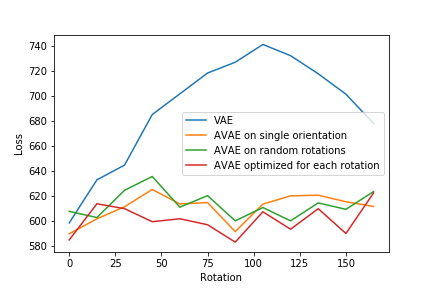

In [5]:
result = Image.open('/media/rene/code/equivariance/imgs/affine_L8_rot_compare_all_sgd20_r40.png')
display(result)

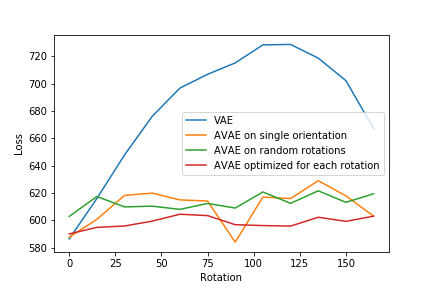

In [8]:
result = Image.open('/media/rene/code/equivariance/imgs/affine_L8_rot_compare_all_sgd20_r20.png')
display(result)

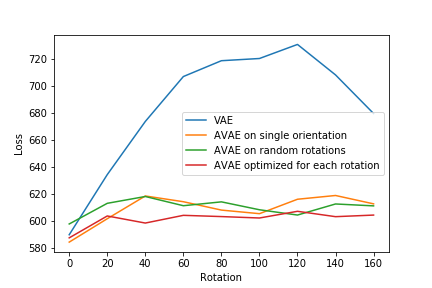

In [6]:
result = Image.open('/media/rene/code/equivariance/imgs/affine_L8_rot_compare_all_sgd20_r30_600t.png')
display(result)

## Results 
* file name is wrong - Actually 600 samples, 20 sgd steps, 30 restarts

In [5]:
results = pd.read_csv('/media/rene/code/equivariance/results/affine_L8_rot_compare_all_sgd20_r30_1000t.csv')
results.head()

,Unnamed: 0,loss_opt_rot,loss_rand_rot,loss_single_rot,loss_single_rot_noopt,rotation
0,0,587.496832,607.060070,589.815239,590.013301,0.0
1,1,598.346440,616.121389,607.743580,630.862346,20.0
2,2,589.162557,607.499783,612.962210,676.839915,40.0
3,3,598.712304,609.125976,614.515579,701.625419,60.0
4,4,599.800915,605.870516,607.716449,712.230999,80.0


In [6]:
results.mean(axis=0)

Unnamed: 0                 4.500000
loss_opt_rot             594.966700
loss_rand_rot            609.302793
loss_single_rot          606.981174
loss_single_rot_noopt    683.397528
rotation                  90.000000
dtype: float64

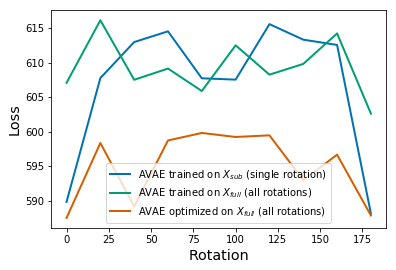

In [9]:
plt.style.use('seaborn-colorblind')
fig, ax = plt.subplots()
ax.plot(results['rotation'], results['loss_single_rot'], label="AVAE trained on $X_{sub}$ (single rotation)",
        linewidth=2)
ax.plot(results['rotation'], results['loss_rand_rot'], label="AVAE trained on $X_{full}$ (all rotations)", 
        linewidth=2)
ax.plot(results['rotation'], results['loss_opt_rot'], label="AVAE optimized on $X_{full}$ (all rotations)", 
        linewidth=2)

ax.set_xlabel('Rotation', fontsize='x-large')
ax.set_ylabel('Loss', fontsize='x-large')
ax.legend(loc='best', prop={'size': 10})
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig('/media/rene/code/equivariance/imgs/affine_L8_rot_AVAE_compare_sgd20_r30_1000t.png', bbox='tight')
plt.show()

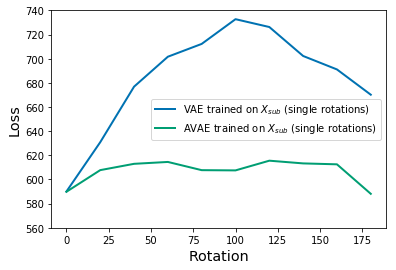

In [8]:
plt.style.use('seaborn-colorblind')

fig, ax = plt.subplots()
ax.plot(results['rotation'], results['loss_single_rot_noopt'], label="VAE trained on $X_{sub}$ (single rotations)",
       linewidth=2)
ax.plot(results['rotation'], results['loss_single_rot'], label="AVAE trained on $X_{sub}$ (single rotations)", 
       linewidth=2)

ax.set_ylim([560,740])
ax.set_xlabel('Rotation', fontsize='x-large')
ax.set_ylabel('Loss', fontsize='x-large')
ax.legend(loc='best', prop={'size': 10})
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig('/media/rene/code/equivariance/imgs/affine_L8_rot_VAE_AVAE_sgd20_r30_1000t.png', bbox='tight')
plt.show()